# imports

In [1]:
from mylib import dataset

from dotenv import dotenv_values
from pathlib import Path
from pprint import pprint, pformat

import pandas as pd
import pandas.api.types as pd_types

import numpy as np

import plotly.express as plotly_px

import joblib

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 50) # Устанавливаем максимальное количество отображаемых столбцов равным 50
#pd.set_option('display.max_rows', 50) # Устанавливаем максимальное количество отображаемых строк равным 20
pd.options.display.float_format = '{:.5f}'.format # Устанавливаем формат отображения чисел с двумя знаками после запятой
pd.options.mode.use_inf_as_na = True # Настройка режима Pandas для рассмотрения бесконечностей (inf) как пропущенных значений (NA)

# Конфигурация формата отображения графиков в виде векторных изображений
%config InlineBackend.figure_format = 'svg'

# для построения графиков внутри Jupyter Notebook
%matplotlib inline

# 1. Загрузка конфигов

In [3]:
# загрузить параметры
settings = {
    **dotenv_values("settings")
}
dataset_folder = str(Path(Path.cwd(), settings["DATASET_SUBFOLDER"]))
result_folder = str(Path(Path.cwd(), settings["RESULT_SUBFOLDER"]))

In [4]:
settings

{'DATASET_SUBFOLDER': 'dataset',
 'RESULT_SUBFOLDER': 'result',
 'CACHE_SUBFOLDER': 'cached_results',
 'DATASET_FILENAME_READY_FOR_TRAIN_StandardScaler': '02_dataset_catencoder_df_ready_for_train_StandardScaler.joblib',
 'DATASET_FILENAME_READY_FOR_TRAIN_MinMaxScaler': '02_dataset_catencoder_df_ready_for_train_MinMaxScaler.joblib',
 'DATASET_FILENAME_READY_FOR_TRAIN_RobustScaler': '02_dataset_catencoder_df_ready_for_train_RobustScaler.joblib',
 'DATASET_FILENAME_READY_FOR_TRAIN_MaxAbsScaler': '02_dataset_catencoder_df_ready_for_train_MaxAbsScaler.joblib',
 'PARAMS_FILENAME_READY_FOR_TRAIN': '02_params_ready_for_train.joblib',
 'GRID_SEARCH_TEMPLATE_FILENAME': '03_GridSearch_%s.joblib',
 'MODEL_CLASS_TEMPLATE_FILENAME': '04_model_%s.joblib'}

# 2. EDA датасета

In [5]:
dataset_df = pd.read_csv(Path(dataset_folder, 'penguins.csv')) #, index_col="id")

In [6]:
display(dataset_df.sample(7))
display(dataset_df.info())

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
36,38.80000,20.00000,190.00000,3950.00000,MALE
179,49.50000,19.00000,200.00000,3800.00000,MALE
273,50.10000,15.00000,225.00000,5000.00000,MALE
146,39.20000,18.60000,190.00000,4250.00000,MALE
259,48.70000,15.70000,208.00000,5350.00000,MALE
190,46.90000,16.60000,192.00000,2700.00000,FEMALE
140,40.20000,17.10000,193.00000,3400.00000,FEMALE


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


None

In [7]:
# выделим числовые и категориальные переменные
params = {}
# columns_X - переменные датасета
params["columns_X"] = dataset_df.columns.to_list()
params["num_columns"] = []
params["cat_columns"] = []
for col in params["columns_X"]:
    if dataset_df[col].nunique() <= 2 or not pd_types.is_numeric_dtype(dataset_df[col]):
        params["cat_columns"].append(col)
    else:
        params["num_columns"].append(col)
print(f'columns_X={params["columns_X"]}')
print(f'cat_columns={pformat(params["cat_columns"])}')
print(f'num_columns={pformat(params["num_columns"])}')

columns_X=['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']
cat_columns=['sex']
num_columns=['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']


In [8]:
dataset_df_describe_num = dataset.eda_df(dataset_df[params["num_columns"]])
display(dataset_df_describe_num)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.00000,342.00000,342.00000,342.00000
mean,43.92193,17.15117,214.01462,4201.75439
std,5.45958,1.97479,260.55806,801.95454
min,32.10000,13.10000,-132.00000,2700.00000
10%,36.60000,14.30000,185.00000,3300.00000
25%,39.22500,15.60000,190.00000,3550.00000
50%,44.45000,17.30000,197.00000,4050.00000
75%,48.50000,18.70000,213.75000,4750.00000
90%,50.80000,19.50000,221.00000,5400.00000
max,59.60000,21.50000,5000.00000,6300.00000


In [9]:
print("Доля пропусков в столбцах в %:")
nan_in_columns = dataset.nans_percents(dataset_df)
# список столбцов с пропусками
params["columns_with_nan"] = nan_in_columns[nan_in_columns > 0].index.to_list()
nan_in_columns[nan_in_columns > 0]

Доля пропусков в столбцах в %:


culmen_length_mm    0.58140
culmen_depth_mm     0.58140
flipper_length_mm   0.58140
body_mass_g         0.58140
sex                 2.61628
dtype: float64

Строк с пустыми переменными немного, посмотрим на них

### Анализ столбцов с измерениями

#### Пропуски

In [10]:
rows_with_all_columns_nan, all_rows_with_nan = dataset.find_rows_with_nan(dataset_df, params["num_columns"])

In [11]:
# Строки, в которых есть что-то пустое
dataset_df.iloc[all_rows_with_nan]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
339,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN


In [12]:
# Строки с полностью пустыми параметрами
dataset_df.iloc[rows_with_all_columns_nan]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
3,NaN,NaN,NaN,NaN,NaN
339,NaN,NaN,NaN,NaN,NaN


In [13]:
# Удалить строки с полностью пустыми значениями
dataset_df.drop(dataset_df.iloc[rows_with_all_columns_nan].index, inplace=True)
dataset_df.reset_index(inplace=True, drop=True)

In [14]:
# проверить, остались ли строки с пустыми столбцами
rows_with_all_columns_nan, all_rows_with_nan = dataset.find_rows_with_nan(dataset_df, params["num_columns"])
dataset_df.iloc[all_rows_with_nan]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex


#### Выбросы

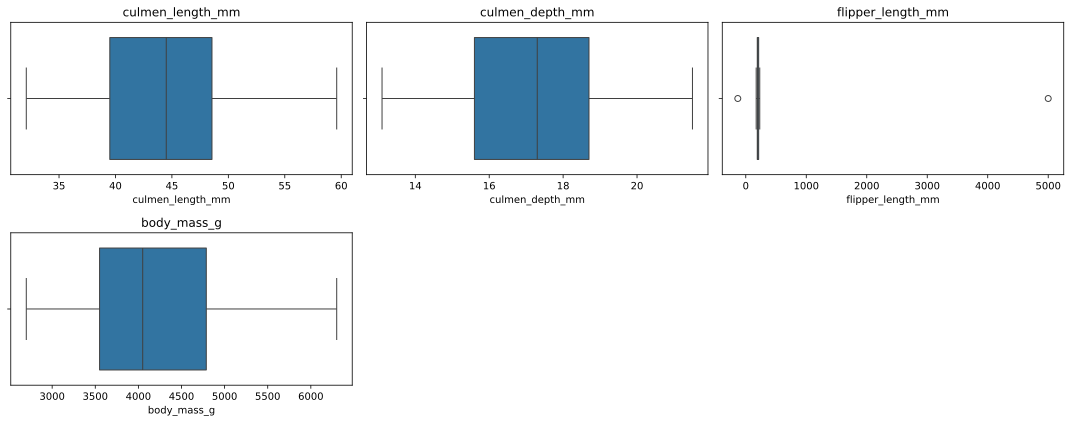

In [15]:
dataset.show_boxes_plt(dataset_df.dropna(), params["num_columns"])

Выбросы только в столбце flipper_length_mm

In [16]:
_, _, _, lower, upper = dataset.iqr_values(dataset_df.dropna()["flipper_length_mm"])
print(f'Нижняя граница: {lower}')
print(f'Верхняя граница: {upper}')

Нижняя граница: 155.5
Верхняя граница: 247.5


In [17]:
dataset_df[(dataset_df["flipper_length_mm"]<lower) | (dataset_df["flipper_length_mm"]>upper)]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
8,42.00000,20.20000,5000.00000,4250.00000,MALE
13,34.60000,21.10000,-132.00000,4400.00000,MALE


Явные выбросы, точнее неправильные значения. Заменим на медиану.

In [18]:
dataset_df.loc[(dataset_df["flipper_length_mm"]<lower) | (dataset_df["flipper_length_mm"]>upper), "flipper_length_mm"] = dataset_df["flipper_length_mm"].median()

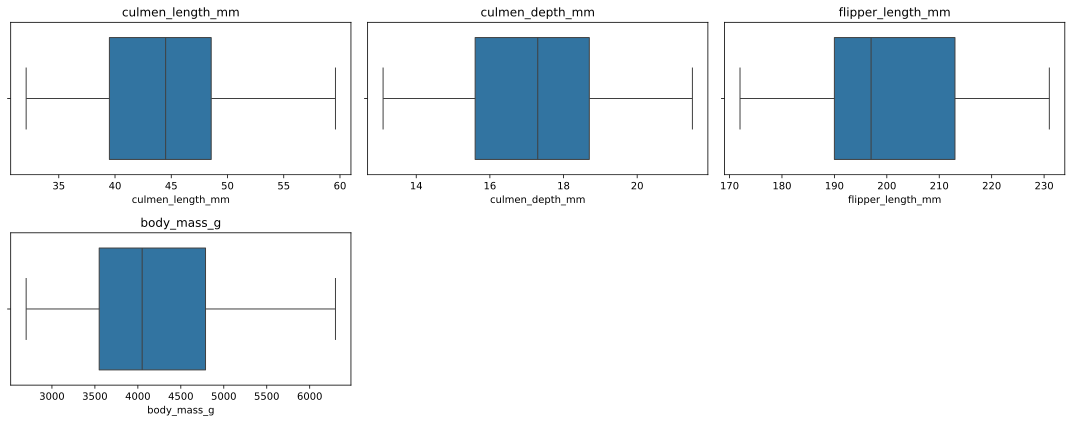

In [19]:
dataset.show_boxes_plt(dataset_df.dropna(), params["num_columns"])

#### Корреляция между столбцами

In [20]:
fig = plotly_px.imshow(dataset_df[params["num_columns"]].corr(), height=1000, width=1000, text_auto='.2f' )
fig.show()

Каких-то значимых корреляций в данных нет.

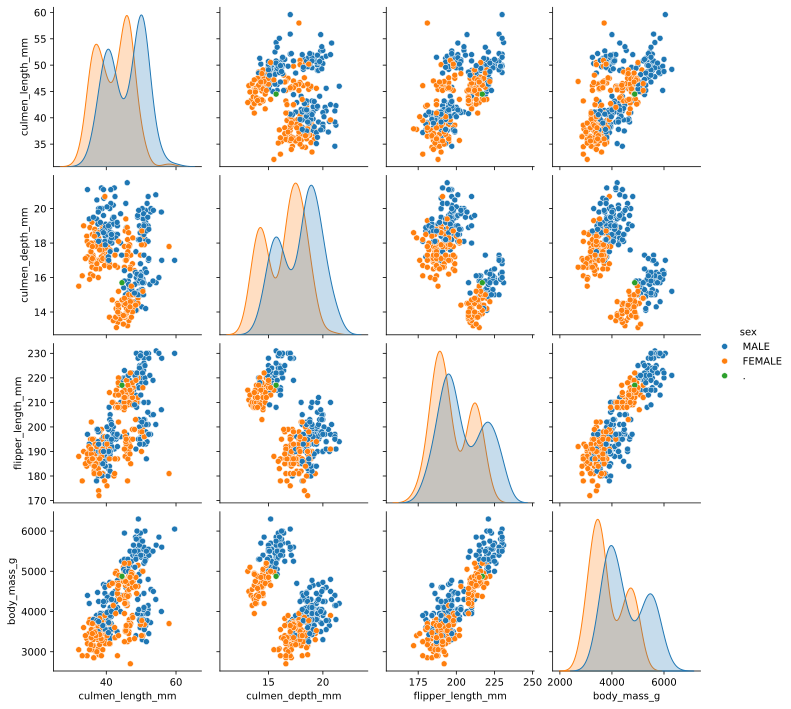

In [21]:
sns.pairplot(dataset_df, hue='sex');# Корреляция между столбцами

### Анализ категориальных столбцов

In [22]:
rows_with_all_columns_nan, all_rows_with_nan = dataset.find_rows_with_nan(dataset_df, params["cat_columns"], debug=True)
dataset_df.iloc[all_rows_with_nan]

Индексы строк с пустым sex: [7, 9, 10, 46, 245, 285, 323]


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
323,47.30000,13.80000,216.00000,4725.00000,NaN
7,34.10000,18.10000,193.00000,3475.00000,NaN
9,37.80000,17.10000,186.00000,3300.00000,NaN
10,37.80000,17.30000,180.00000,3700.00000,NaN
46,37.50000,18.90000,179.00000,2975.00000,NaN
245,44.50000,14.30000,216.00000,4100.00000,NaN
285,46.20000,14.40000,214.00000,4650.00000,NaN


In [23]:
print("Уникальные значения по столбцам")
nunique = dataset_df[params["cat_columns"]].nunique()
for column in nunique.index:
    if nunique[column] <= 10:
        print(f'{column:20}: {nunique[column]:6}, {dataset_df[column].unique().tolist()}')
    else:
        print(f'{column:20}: {nunique[column]:6}')
    display(dataset_df[column].value_counts())

Уникальные значения по столбцам
sex                 :      3, ['MALE', 'FEMALE', nan, '.']


sex
MALE      169
FEMALE    165
.           1
Name: count, dtype: int64

In [24]:
# Есть несколько пропусков и одно некорректное значение. Посмотрим на эти строки
dataset_df.loc[(dataset_df['sex']!='MALE') & (dataset_df['sex']!='FEMALE')]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
7,34.10000,18.10000,193.00000,3475.00000,NaN
9,37.80000,17.10000,186.00000,3300.00000,NaN
10,37.80000,17.30000,180.00000,3700.00000,NaN
46,37.50000,18.90000,179.00000,2975.00000,NaN
245,44.50000,14.30000,216.00000,4100.00000,NaN
285,46.20000,14.40000,214.00000,4650.00000,NaN
323,47.30000,13.80000,216.00000,4725.00000,NaN
335,44.50000,15.70000,217.00000,4875.00000,.


In [25]:
# Заменить "неправильные" значения sex на моду
dataset_df['sex'] = np.where((dataset_df['sex']!='MALE') & (dataset_df['sex']!='FEMALE'), dataset_df['sex'].mode(), dataset_df['sex'])

In [26]:
# Проверить на наличие некорректных значений
dataset_df.loc[(dataset_df['sex']!='MALE') & (dataset_df['sex']!='FEMALE')]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex


# Нормализовать данные

In [27]:
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler,
                                   RobustScaler,
                                   MaxAbsScaler
                                   )
dataset_df_not_scaled = dataset_df[params["num_columns"]]
dataset_df_StandardScaler = StandardScaler().fit_transform(dataset_df[params["num_columns"]])
dataset_df_MinMaxScaler = MinMaxScaler().fit_transform(dataset_df[params["num_columns"]])
dataset_df_RobustScaler = RobustScaler().fit_transform(dataset_df[params["num_columns"]])
dataset_df_MaxAbsScaler = MaxAbsScaler().fit_transform(dataset_df[params["num_columns"]])

In [28]:
def draw_reduced_data(reduced_data, title, dataset):
    # Построение графика
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_data[:, 0], 
                reduced_data[:, 1], 
                c=[sns.color_palette()[x] for x in dataset.sex.map({"MALE":0, "FEMALE":1})], 
                edgecolor='k', s=50)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

# Kernel PCA

In [29]:
from sklearn.decomposition import KernelPCA

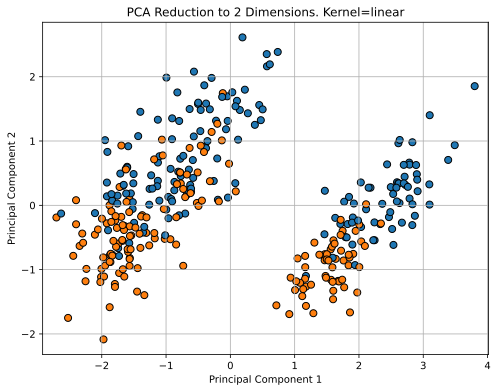

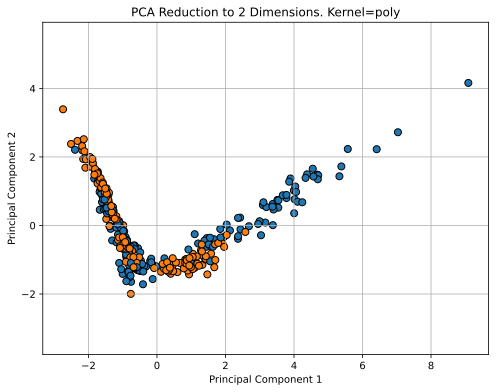

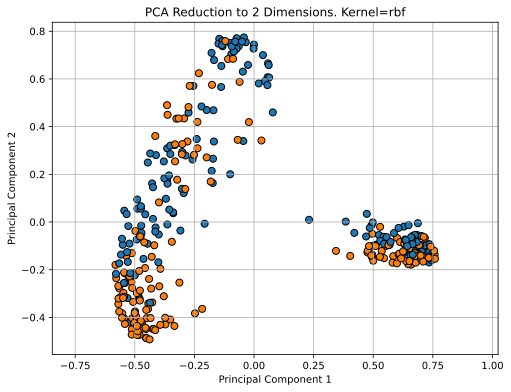

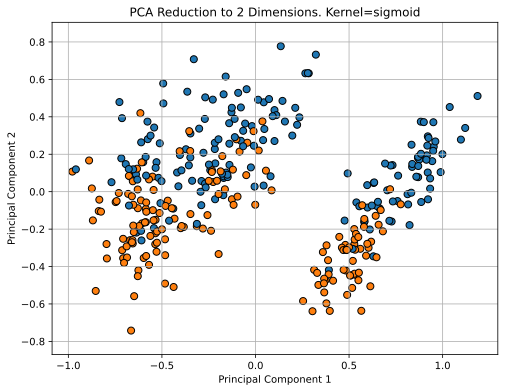

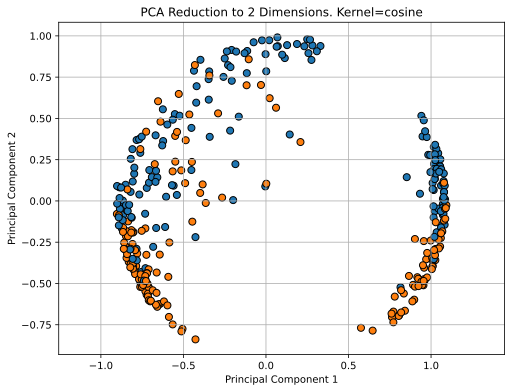

In [30]:
kernels = {'linear': {}, 'poly': {}, 'rbf': {}, 'sigmoid': {}, 'cosine': {}}
for kernel in kernels:
    kpca = KernelPCA(n_components=2, kernel=kernel, random_state=42)
    reduced_data_kpca = kpca.fit_transform(dataset_df_StandardScaler)
    draw_reduced_data(reduced_data_kpca, 
                      f'PCA Reduction to 2 Dimensions. Kernel={kernel}', 
                      dataset_df)
    #draw_kernel_reduced_data(kernels, kernel)


Предполагаю, что ядро *poly* дает наихудший результат. 
Остальные дают сопоставимые результаты.

# PCA

In [31]:
from sklearn.decomposition import PCA

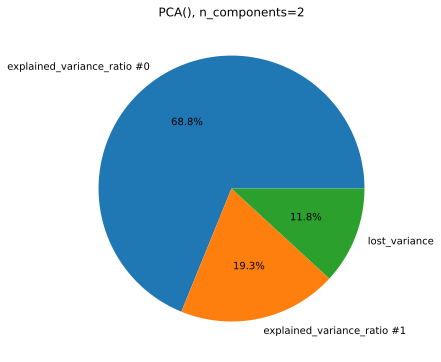

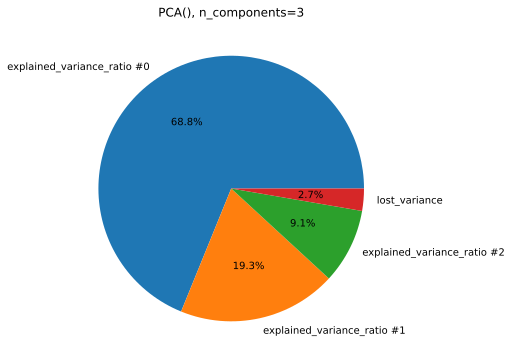

In [32]:
for n in [2, 3]:
    pca_linear = PCA(n_components=n, random_state=42)
    reduced_data_pca = pca_linear.fit_transform(dataset_df_StandardScaler)
    explained_variance_ratio = pca_linear.explained_variance_ratio_
    total_explained_variance = np.sum(explained_variance_ratio)
    lost_variance = 1 - total_explained_variance
    values = list(explained_variance_ratio) + [lost_variance]
    labels = [f"explained_variance_ratio #{i}" for i, _ in enumerate(explained_variance_ratio)] + ["lost_variance"]
    plt.figure(figsize=(8, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    plt.title(f"PCA(), n_components={pca_linear.n_components_}")
    plt.show()

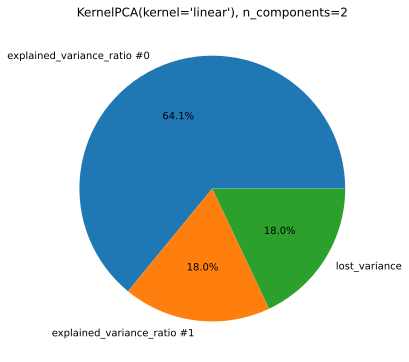

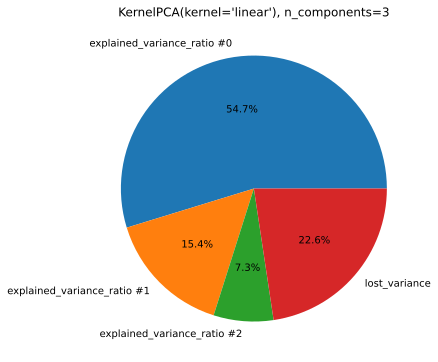

In [33]:
for n in [2, 3]:

    kpca_linear = KernelPCA(n_components=n, random_state=42, kernel="linear")
    reduced_data_kpca_linear = kpca_linear.fit_transform(dataset_df_StandardScaler)

    # объясненная дисперсия по компонентам
    explained_variance = np.var(reduced_data_kpca_linear, axis=0)
    explained_variance_ratio = explained_variance / np.sum(explained_variance)
    # общая объясненная дисперсия
    total_explained_variance =  np.cumsum(explained_variance_ratio)[0]
    # потерянная дисперсия                                                                
    lost_variance = 1 - total_explained_variance
    values = list(explained_variance_ratio) + [lost_variance]
    labels = [f"explained_variance_ratio #{i}" for i, _ in enumerate(explained_variance_ratio)] + ["lost_variance"]
    plt.figure(figsize=(8, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    plt.title(f"KernelPCA(kernel='linear'), n_components={kpca_linear.n_components}")
    plt.show()

PCA() c тремя компонентами описывает наилуччшим образом - lost-variance-ratio всего 2.7%. При этом первый компонент объясняет 61.4% данных.
Для KernelPCA с ядром 'linear' и двумя компонентами дает lost-variance-ratio 22.6%.

# t-SNE

In [34]:
from sklearn.manifold import TSNE # TSNE: Если столбцов признаков > 50, то применяется PCA с n до 50, а затем уже TSNE

In [35]:
# Применение TSNE для снижения размерности до 2
tsne = TSNE(n_components=2, random_state=42)

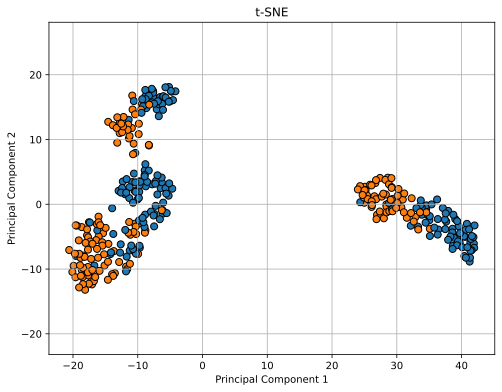

In [36]:
reduced_data_tsne = tsne.fit_transform(dataset_df_StandardScaler)
draw_reduced_data(reduced_data_tsne, f't-SNE', dataset_df)

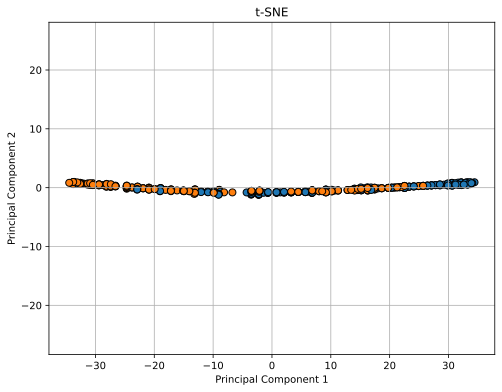

In [37]:
reduced_data_tsne = tsne.fit_transform(dataset_df_not_scaled)
draw_reduced_data(reduced_data_tsne, f't-SNE', dataset_df)

# UMAP

In [38]:
#!pip install umap-learn
#!pip install holoviews
#!pip install datashader
import umap
import umap.plot

In [39]:
umap_m = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean')

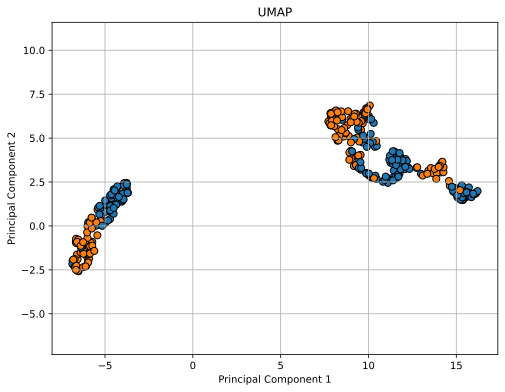

In [40]:
reduced_data_umap = umap_m.fit_transform(dataset_df_StandardScaler)
draw_reduced_data(reduced_data_umap, f'UMAP', dataset_df)

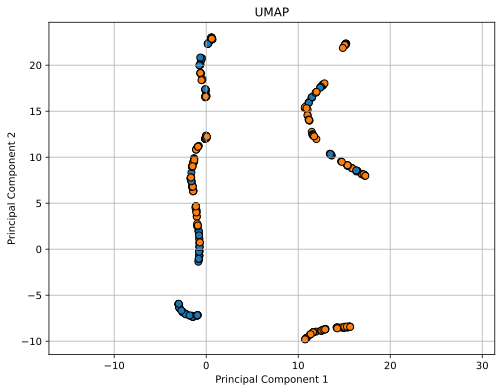

In [41]:
reduced_data_umap = umap_m.fit_transform(dataset_df_not_scaled)
draw_reduced_data(reduced_data_umap, f'UMAP', dataset_df)

На нормализованных данных t-SNE и UMAP дают по два четко выделенных кластера.